In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
file = 'ttbar.root'
df = ROOT.RDataFrame("Events", file)

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


In [3]:
# Define scuared generator weight to help compute error bars 
df = df.Define("genWeight2", "pow(genWeight, 2)")

In [4]:
# Function to if event has BHadrons
LeadBHadron ="""
pair<int, float> LeadBHadron(
ROOT::RVec<int> FlavourID, 
ROOT::RVec<float> ParticlePt)
{
    int nPart = FlavourID.size();
    int LeadId = 0;
    float LeadPt = 0.0;

    // Loop through particles
    for (int idx = 0; idx < nPart; idx++){
        int CandVal = FlavourID[idx];
        float CandPt = ParticlePt[idx];

        // Check if the particle is B hadron
        if (((abs(CandVal) >= 500 && abs(CandVal) < 600) || (abs(CandVal) >= 5000 && abs(CandVal) < 6000)) && (CandPt > LeadPt)){
            LeadId = CandVal;
            LeadPt = CandPt;
        }
    }
    return std::make_pair(LeadId, LeadPt);
}

"""

ROOT.gInterpreter.Declare(LeadBHadron)

True

In [5]:
# Function to if event has BHadrons
LeadHadron ="""
pair<int, float> LeadHadron(
ROOT::RVec<int> FlavourID, 
ROOT::RVec<float> ParticlePt)
{
    int nPart = FlavourID.size();
    int LeadId = 0;
    float LeadPt = 0.0;

    // Loop through particles
    for (int idx = 0; idx < nPart; idx++){
        int CandVal = FlavourID[idx];
        float CandPt = ParticlePt[idx];

        // Check if the particle is B hadron
        if ((abs(CandVal) >= 100 ) && (CandPt > LeadPt)){
            LeadId = CandVal;
            LeadPt = CandPt;
        }
    }
    return std::make_pair(LeadId, LeadPt);
}

"""

ROOT.gInterpreter.Declare(LeadHadron)

True

In [6]:
# Define the leading hadron pdgId and pt if it includes b quark 
df = (df.Define("LeadHadron", "LeadHadron(GenPart_pdgId, GenPart_pt)")
        .Define("LeadHadron_pdgId", "LeadHadron.first")
        .Define("LeadHadron_pt", "LeadHadron.second"))

In [7]:
# Create dataframes for reference values
df_Bpm = df.Filter("abs(LeadHadron_pdgId) == 521", "Filter plus and minus meson")
df_Bp = df.Filter("LeadHadron_pdgId == 521", "Filter plus meson")
df_B0 = df.Filter("LeadHadron_pdgId == 511", "Filter neutral meson")
df_Bs = df.Filter("LeadHadron_pdgId == 531", "Filter strange meson")
df_BL = df.Filter("LeadHadron_pdgId == 5122", "Filter Lambda")
df_BHad = df.Filter("((abs(LeadHadron_pdgId) >= 500 && abs(LeadHadron_pdgId) < 600) || (abs(LeadHadron_pdgId) >= 5000 && abs(LeadHadron_pdgId) < 6000))", "Filter events with B hadron")

In [8]:
df_BHad.Report().Print()

Filter events with B hadron: pass=363013     all=379950     -- eff=95.54 % cumulative eff=95.54 %


In [9]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Only computed from largest hadron
semileptonic_decay = """
pair<ROOT::RVec<int>, float> SemileptonicDecay(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<int> ReturnVector;
float ReturnPt = 0;

// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if ((abs(Flavour) == 13) || (abs(Flavour) == 11)){

        // Initialize the while loop
        int Idx = ii;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        // Trace back the decay chain
        while (!IsBHadron && !FromHardProcess && Idx != -1){
            Idx = MotherIdx[Idx];
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsBHadron = (abs(Flavour) >= 500 && abs(Flavour) < 600) || (abs(Flavour) >= 5000 && abs(Flavour) < 6000);
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector = CandVector;
                ReturnPt = CandPt;
            }
        }
    }
}

return std::make_pair(ReturnVector, ReturnPt);

}

"""

ROOT.gInterpreter.Declare(semileptonic_decay)

True

In [10]:
# Track the decay chains
df = (df.Define("SemileptonicBHadronChain", "SemileptonicDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt)")
        .Define("SemileptonicBHadronChain_pdgId", "SemileptonicBHadronChain.first")
        .Define("SemileptonicBHadronChain_pt", "SemileptonicBHadronChain.second"))

In [11]:
df_fraction = df.Filter("rdfentry_ % 100 == 0")
columns = ["LeadHadron_pdgId", "LeadHadron_pt"]
data = df_fraction.AsNumpy(columns)
df_pandas = pd.DataFrame(data)
print(df_pandas.to_string())

      LeadHadron_pdgId  LeadHadron_pt
0                  513       58.50000
1                  310       53.75000
2                  523       76.50000
3                 -523       55.37500
4                  513       91.50000
5                 -513       36.25000
6                  513       47.12500
7                 -511       39.87500
8                  513       67.00000
9                 -521       23.75000
10                -523       30.37500
11                 513       40.75000
12                -523       70.00000
13                 511       48.75000
14                -513       73.50000
15                 513       67.00000
16                 513       47.50000
17                -523       62.87500
18                -513       55.37500
19                -523       70.00000
20                 513       28.06250
21                -523       45.00000
22                -521       60.75000
23                -523       51.50000
24                 311      120.50000
25          

In [12]:
# Create a dataframe for events with lead hadron decaying semileptonically
df_BHad_SL = (df.Filter("SemileptonicBHadronChain_pt > 0", "Filter events with semileptonic BHadron decay")
                .Filter("(SemileptonicBHadronChain_pdgId.back() == LeadHadron_pdgId) && (abs(SemileptonicBHadronChain_pt - LeadHadron_pt) < 10e-5)", "Filter semileptonic decays from the lead hadron"))

In [13]:
# Filter events that decay through tau and directly
df_tau = (df_BHad_SL.Filter("(std::find(SemileptonicBHadronChain_pdgId.begin(), SemileptonicBHadronChain_pdgId.end(), 15) != SemileptonicBHadronChain_pdgId.end()) ||(std::find(SemileptonicBHadronChain_pdgId.begin(), SemileptonicBHadronChain_pdgId.end(), 15) != SemileptonicBHadronChain_pdgId.end())" ,
    "Decays through tau")
                    .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt"))
df_direct = (df_BHad_SL.Filter("SemileptonicBHadronChain_pdgId.size() == 2", "Decays immediately")
                       .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt"))

In [14]:
# Checks if there is intermediate charm or anticharm hadron in decay chain 
charm_decay = """
bool CharmDecay(
ROOT::RVec<int> DecayChain,
bool AntiPart
){
int nPart = DecayChain.size();
int Flavour;

if (!AntiPart){
    for (int ii = 0; ii < nPart; ii++){
        Flavour = DecayChain[ii];
        if ((Flavour >= 400 && Flavour < 500) || (Flavour >= 4000 && Flavour < 5000)){
            return true;
        }
    }
}

else{
    for (int ii = 0; ii < nPart; ii++){
        Flavour = DecayChain[ii];
        if ((Flavour <= -400 && Flavour > -500) || (Flavour <= -4000 && Flavour > -5000)){
            return true;
        }
    }
}
return false;
}

"""
ROOT.gInterpreter.Declare(charm_decay)

True

In [15]:
# Filter events decaying through charm and anticharm
df_charm = (df_BHad_SL.Filter("CharmDecay(SemileptonicBHadronChain_pdgId, false)", "Decays through charm")
                      .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt"))
df_anticharm = (df_BHad_SL.Filter("CharmDecay(SemileptonicBHadronChain_pdgId, true)", "Decays through anti charm")
                          .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt"))

In [16]:
df_fraction = df_charm.Filter("rdfentry_ % 10 == 0")
columns = ["SemileptonicBHadronChain_pdgId", "SemileptonicBHadronChain_pt", "LeadHadron_pt"]
data = df_fraction.AsNumpy(columns)
df_pandas = pd.DataFrame(data)
print(df_pandas.to_string())

        SemileptonicBHadronChain_pdgId  SemileptonicBHadronChain_pt  LeadHadron_pt
0             [11, 111, 431, 433, 521]                     51.62500       51.62500
1                     [-13, 411, -511]                     39.87500       39.87500
2                     [-11, 411, -511]                     63.37500       63.37500
3                [-11, 411, 415, -511]                     44.12500       44.12500
4                      [-13, 411, 511]                     50.12500       50.12500
5                     [-13, 421, -521]                     87.00000       87.00000
6                [-11, 421, 423, -521]                    119.00000      119.00000
7                [11, 221, 4122, 5122]                    126.00000      126.00000
8                 [11, 111, 421, -521]                     61.87500       61.87500
9                      [-13, 431, 511]                    111.75000      111.75000
10               [-11, 421, 423, -521]                     75.25000       75.25000
11  

In [17]:
df_fraction = df_anticharm.Filter("rdfentry_ % 10 == 0")
columns = ["SemileptonicBHadronChain_pdgId", "SemileptonicBHadronChain_pt", "LeadHadron_pt"]
data = df_fraction.AsNumpy(columns)
df_pandas = pd.DataFrame(data)
print(df_pandas.to_string())

           SemileptonicBHadronChain_pdgId  SemileptonicBHadronChain_pt  LeadHadron_pt
0                  [11, -431, -433, -531]                      24.6250        24.6250
1                         [11, -431, 531]                      85.2500        85.2500
2                   [11, -431, -433, 531]                      70.0000        70.0000
3             [11, 111, -421, -423, -521]                      73.2500        73.2500
4                  [11, 111, -413, -5122]                      50.8750        50.8750
5                         [13, -411, 511]                     269.0000       269.0000
6                   [11, -421, -423, 521]                      54.1250        54.1250
7                   [13, -421, -423, 521]                      80.7500        80.7500
8                         [11, -411, 511]                     109.7500       109.7500
9              [11, 111, -421, -423, 521]                      84.0000        84.0000
10                       [11, -411, -511]             

In [18]:
# Filter events that decay semileptonically from specific meson or baryon
df_charged_mesons = (df_BHad_SL.Filter("abs(SemileptonicBHadronChain_pdgId.back()) == 521", "Filter decays from charged mesons")
                               .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt")
                               .Filter("SemileptonicBHadronChain_pdgId.size() == 2", "Decays directly"))
df_uncharged_mesons = (df_BHad_SL.Filter("SemileptonicBHadronChain_pdgId.back() == 511", "Filter decays from uncharged mesons")
                                .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt")
                               .Filter("SemileptonicBHadronChain_pdgId.size() == 2", "Decays directly"))
df_strange_mesons = (df_BHad_SL.Filter("SemileptonicBHadronChain_pdgId.back() == 531 || abs(SemileptonicBHadronChain_pdgId.back()) == 541", "Filter decays from strange mesons")
                               .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt")
                               .Filter("SemileptonicBHadronChain_pdgId.size() == 2", "Decays directly"))
df_Lambda = (df_BHad_SL.Filter("SemileptonicBHadronChain_pdgId.back() == 5122", "Filter decays from Lambda")
                       .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt")
                        .Filter("SemileptonicBHadronChain_pdgId.size() == 2", "Decays directly"))


In [19]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Only computed from largest hadron
inclusive_decay = """
pair<ROOT::RVec<int>, float> InclusiveDecay(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt,
int DecayProduct
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<int> ReturnVector;
float ReturnPt = 0;

// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if (abs(Flavour) == DecayProduct){

        // Initialize the while loop
        int Idx = ii;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        // Trace back the decay chain
        while (!IsBHadron && !FromHardProcess && Idx != -1){
            Idx = MotherIdx[Idx];
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsBHadron = (abs(Flavour) >= 500 && abs(Flavour) < 600) || (abs(Flavour) >= 5000 && abs(Flavour) < 6000);
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector = CandVector;
                ReturnPt = CandPt;
            }
        }
    }
}

return std::make_pair(ReturnVector, ReturnPt);

}

"""

ROOT.gInterpreter.Declare(inclusive_decay)

True

In [20]:
# Compute decay chains for inclusive decays
df = (df.Define("InclusiveUnchargedChain", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 421)")
        .Define("InclusiveUnchargedChain_pdgId", "InclusiveUnchargedChain.first")
        .Define("InclusiveUnchargedChain_pt", "InclusiveUnchargedChain.second"))

df = (df.Define("InclusiveChargedChain", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 411)")
        .Define("InclusiveChargedChain_pdgId", "InclusiveUnchargedChain.first")
        .Define("InclusiveChargedChain_pt", "InclusiveUnchargedChain.second"))

df = (df.Define("InclusiveStrangeChain", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 431)")
        .Define("InclusiveStrangeChain_pdgId", "InclusiveStrangeChain.first")
        .Define("InclusiveStrangeChain_pt", "InclusiveStrangeChain.second"))

In [21]:
# Filter separate inclusive decays
df_inclusive_uncharged = (df.Filter("InclusiveUnchargedChain_pt > 0", "Filter events with inclusive uncharged Meson decay")
                            .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt"))

df_inclusive_charged = (df.Filter("InclusiveChargedChain_pt > 0", "Filter events with inclusive charged Meson decay")
                          .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt"))

df_inclusive_strange = (df.Filter("InclusiveStrangeChain_pt > 0", "Filter events with inclusive strange Meson decay")
                          .Filter("SemileptonicBHadronChain_pt == LeadHadron_pt"))

In [22]:
# More specific cuts
df_inclusive_unchargedB0 = df_inclusive_uncharged.Filter("InclusiveUnchargedChain_pdgId.back() == 521", "Filter decays from charged mesons")
df_inclusive_chargedB0 = df_inclusive_charged.Filter("InclusiveChargedChain_pdgId.back() == 521", "Filter decays from uncharged mesons")
df_inclusive_strangeB0 = df_inclusive_strange.Filter("InclusiveStrangeChain_pdgId.back() == 521", "Filter decays from strange mesons")

df_inclusive_unchargedBp = df_inclusive_uncharged.Filter("InclusiveUnchargedChain_pdgId.back() == 511", "Filter decays from charged mesons")
df_inclusive_chargedBp = df_inclusive_charged.Filter("InclusiveChargedChain_pdgId.back() == 511", "Filter decays from charged mesons")
df_inclusive_strangeBp = df_inclusive_strange.Filter("InclusiveStrangeChain_pdgId.back() == 511", "Filter decays from charged mesons")

In [23]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Takes also charge into account
inclusive_decay_charge = """
pair<ROOT::RVec<int>, float> InclusiveDecayCharge(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt,
int DecayProduct
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<int> ReturnVector;
float ReturnPt = 0;

// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if (Flavour == DecayProduct){

        // Initialize the while loop
        int Idx = ii;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        // Trace back the decay chain
        while (!IsBHadron && !FromHardProcess && Idx != -1){
            Idx = MotherIdx[Idx];
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsBHadron = (abs(Flavour) >= 500 && abs(Flavour) < 600) || (abs(Flavour) >= 5000 && abs(Flavour) < 6000);
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector = CandVector;
                ReturnPt = CandPt;
            }
        }
    }
}

return std::make_pair(ReturnVector, ReturnPt);

}

"""

ROOT.gInterpreter.Declare(inclusive_decay_charge)

True

In [24]:
# Define filtering conditions for inclusive decay to negative strange d meson
df = (df.Define("InclusiveNegStrangeChain", "InclusiveDecayCharge(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, -431)")
        .Define("InclusiveNegStrangeChain_pdgId", "InclusiveNegStrangeChain.first")
        .Define("InclusiveNegStrangeChain_pt", "InclusiveNegStrangeChain.second"))

In [25]:
# Filter accordingly
df_inclusive_strange_neg = df.Filter("InclusiveNegStrangeChain_pt > 0", "Filter decays to strange negative mesons")
df_inclusive_strange_neg = df_inclusive_strange_neg.Filter("InclusiveNegStrangeChain_pdgId.back() == 511", "Filter decays from charged mesons")

In [26]:
df_fraction = df_B0.Filter("rdfentry_ % 100 == 0")
columns = ["LeadHadron_pdgId", "LeadHadron_pt"]
data = df_fraction.AsNumpy(columns)
df_pandas = pd.DataFrame(data)
print(df_pandas.to_string())

     LeadHadron_pdgId  LeadHadron_pt
0                 511        48.7500
1                 511       103.2500
2                 511       102.2500
3                 511        55.7500
4                 511       106.2500
5                 511        60.0000
6                 511       101.2500
7                 511        77.5000
8                 511        54.5000
9                 511       312.0000
10                511        21.5625
11                511        84.2500
12                511        91.7500
13                511        90.5000
14                511        57.1250
15                511        59.6250
16                511        45.1250
17                511        77.5000
18                511       125.5000
19                511       115.7500
20                511        36.3750
21                511       138.5000
22                511        74.7500
23                511       119.2500
24                511       109.0000
25                511        46.7500
2

In [27]:
df_fraction = df_charged_mesons.Filter("rdfentry_ % 10 == 0")
columns = ["SemileptonicBHadronChain_pdgId", "SemileptonicBHadronChain_pt", "LeadHadron_pt"]
data = df_fraction.AsNumpy(columns)
df_pandas = pd.DataFrame(data)
print(df_pandas.to_string())

     SemileptonicBHadronChain_pdgId  SemileptonicBHadronChain_pt  LeadHadron_pt
0                        [11, -521]                    133.00000      133.00000
1                        [13, -521]                    115.75000      115.75000
2                        [11, -521]                     46.00000       46.00000
3                        [11, -521]                     45.12500       45.12500
4                        [-11, 521]                     84.00000       84.00000
5                        [11, -521]                    130.00000      130.00000
6                        [-11, 521]                     46.87500       46.87500
7                        [11, -521]                     60.75000       60.75000
8                        [-13, 521]                     59.12500       59.12500
9                        [11, -521]                    127.75000      127.75000
10                       [-13, 521]                     81.75000       81.75000
11                       [-13, 521]     

In [ ]:
class Rescale():
    def __init__(self):
        self.Total_df = None                                                            # ROOT Dataframe including all decay channels 
        self.bins = None                                                                # x value
        self.intervals = None                                                           # Array of intervals 
        self.branching_ratios = pd.DataFrame(columns=['Decay product', 'BR', 'CI'])     # DataFrame for the results

        self.branching_ratio_p8 = {}                                                    # Df for pt bin values 
        self.branching_ratio_pdg = {}                                                   # Df for references
        self.scaling_factors = {}                                           
        self.error_bars_pdg = {}
        self.error_bars = {}
        self.colors = {}



    def Branching_ratio(self, Decay_df, Name, Z=1.645):

        # Weighted sums directly from ROOT RDataFrame
        nTotal = self.Total_df.Sum("genWeight").GetValue()
        nDecay = Decay_df.Sum("genWeight").GetValue()

        # Effective number of events from weight variance
        W = self.Total_df.Sum("genWeight2").GetValue()
        Neff = nTotal**2 / W if W > 0 else 0

        # Branching ratio and confidence interval
        BR = nDecay / nTotal if nTotal > 0 else 0
        CI = Z * np.sqrt((BR * (1 - BR)) / Neff) if Neff > 0 else 0

        # Store results
        self.branching_ratios.loc[len(self.branching_ratios)] = {
            'Decay product': Name,
            'BR': BR,
            'CI': CI
        }

    def Branching_ratio_pt(self, intervals, Decay_df, Name, Z=1.645):
        self.intervals = np.array(intervals)
        self.bins = 0.5 * (self.intervals[:-1] + self.intervals[1:])

        # Histograms for total and decay counts
        h_total = self.Total_df.Histo1D(
            ("h_total", "LeadHadron_pt", len(intervals)-1, intervals),
            "LeadHadron_pt", "genWeight"
        )
        h_decay = Decay_df.Histo1D(
            ("h_decay", "LeadHadron_pt", len(intervals)-1, intervals),
            "LeadHadron_pt", "genWeight"
        )

        # Histograms for weight^2 sums
        h_total_w2 = self.Total_df.Histo1D(
            ("h_total_w2", "LeadHadron_pt", len(intervals)-1, intervals),
            "LeadHadron_pt", "genWeight2"
        )

        # Convert to numpy bin contents (ignore under/overflow bins)
        nTotal = np.array([h_total.GetValue().GetBinContent(i+1) for i in range(len(intervals)-1)])
        nDecay = np.array([h_decay.GetValue().GetBinContent(i+1) for i in range(len(intervals)-1)])
        W = np.array([h_total_w2.GetValue().GetBinContent(i+1) for i in range(len(intervals)-1)])
        

        Neff = nTotal**2 / W
        BR = nDecay / nTotal
        CI = Z * np.sqrt((BR * (1 - BR)) / Neff)

        self.branching_ratio_p8[Name] = BR.tolist()
        self.error_bars[Name] = CI.tolist()


    # Add reference value and corresponding color
    def add_pdgBR(self, Name, val, color):
        self.branching_ratio_pdg[Name] = val
        self.colors[Name] = color

    # Plotting the results
    def plot_results(self):
        hep.style.use("CMS")

        # Bin widths for xerr
        x_error = 0.5 * (self.intervals[1:] - self.intervals[:-1])

        # Scaling factors
        self.scaling_factors = {
            k: np.array(self.branching_ratio_p8[k]) / np.array(self.branching_ratio_pdg[k])
            for k in self.branching_ratio_p8.keys()
        }

        # Plot for branching ratios (figure 1)
        fig1, ax1 = plt.subplots(figsize=(7, 5))

        for ch in self.branching_ratio_p8.keys():
            br_vals = np.array(self.branching_ratio_p8[ch])
            br_errs = np.array(self.error_bars[ch])
            pdg_vals = np.array(self.branching_ratio_pdg[ch])

            ax1.errorbar(
                self.bins, br_vals,
                yerr=br_errs, xerr=x_error,
                fmt="o", color=self.colors[ch], label=f"{ch} P8",
                markersize = 3, lw = 0.8
            )

            if pdg_vals.size == 1:
                ax1.axhline(pdg_vals, linestyle="--", color=self.colors[ch], alpha=0.7, label=f"{ch} PDG", lw = 0.8)
            else:
                ax1.plot(self.bins, pdg_vals, linestyle="--", color=self.colors[ch], alpha=0.7, label=f"{ch} PDG", lw = 0.8)

        ax1.set_xscale("log")
        ax1.set_xlabel(r"$p_T^{\mathrm{gen},\mathrm{hadron}}$ (GeV)", fontsize = 10)
        ax1.set_ylabel("Branching ratio", fontsize = 10)
        ax1.legend(fontsize=9)
        ax1.set_ylim(0, 0.2)

        ax1.tick_params(axis='both', which='major', labelsize=8)  
        ax1.tick_params(axis='both', which='minor', labelsize=6)

        plt.tight_layout()
        plt.show()

        # Plot for scaling factors (figure 2)
        fig2, ax2 = plt.subplots(figsize=(7, 5))

        for ch in self.scaling_factors.keys():
            sf_vals = np.array(self.scaling_factors[ch])
            ax2.errorbar(
                self.bins, sf_vals,
                yerr=0.05, xerr=x_error,
                fmt="o", color=self.colors[ch], label=ch,
                markersize = 3, lw = 0.8
            )
            ax2.axhline(1.0, linestyle="--", color=self.colors[ch], alpha=0.3, lw = 0.8)

        ax2.set_xscale("log")
        ax2.set_xlabel(r"$p_T^{\mathrm{gen},\mathrm{hadron}}$ (GeV)", fontsize = 10)
        ax2.set_ylabel("Scaling factor", fontsize = 10)
        ax2.legend(fontsize=9)
        ax2.set_ylim(0, 2)

        ax2.tick_params(axis='both', which='major', labelsize=8)  
        ax2.tick_params(axis='both', which='minor', labelsize=6)

        plt.tight_layout()
        plt.show()


In [29]:
# Create pandas dataframe for the semileptonic branching ratios
semileptonic = Rescale()
semileptonic.Total_df = df_BHad

semileptonic.Branching_ratio(df_direct, "b→µ/e")
semileptonic.Branching_ratio(df_tau, "b→τ →µ/e ")
semileptonic.Branching_ratio(df_charm, "b→c→µ/e")
semileptonic.Branching_ratio(df_anticharm, "b→¯c→µ/e")

print(semileptonic.branching_ratios.to_string())

  Decay product        BR        CI
0         b→µ/e  0.068993  0.000697
1     b→τ →µ/e   0.002380  0.000134
2       b→c→µ/e  0.030451  0.000473
3      b→¯c→µ/e  0.030229  0.000471


In [30]:
%%script false --no raise error
# Pandas dataframe for the specific hadrons
semileptonicB0 = Rescale(df_B0)
semileptonicBpm = Rescale(df_Bpm)
semileptonicBs = Rescale(df_Bs)
semileptonicL = Rescale(df_BL)

semileptonicB0.Branching_ratio(df_uncharged_mesons, 'B0')
semileptonicBpm.Branching_ratio(df_charged_mesons, 'Bpm')
semileptonicBs.Branching_ratio(df_strange_mesons, 'Bs')
semileptonicL.Branching_ratio(df_Lambda, 'L')

semileptonic_individual = semileptonicB0.branching_ratios
semileptonic_individual = pd.concat([semileptonic_individual, semileptonicBpm.branching_ratios], ignore_index=True)
semileptonic_individual = pd.concat([semileptonic_individual, semileptonicBs.branching_ratios], ignore_index=True)
semileptonic_individual = pd.concat([semileptonic_individual, semileptonicL.branching_ratios], ignore_index=True)
print(semileptonic_individual.to_string())

In [31]:
%%script false --no raise error
# Pandas dataframe for inclusive decays
inclusiveB0 = Rescale(df_B0)
inclusiveBp = Rescale(df_Bp)
inclusiveBs = Rescale(df_Bs)

inclusiveB0.Branching_ratio(df_inclusive_unchargedB0, 'D0')
inclusiveB0.Branching_ratio(df_inclusive_chargedB0, 'Dpm')
inclusiveB0.Branching_ratio(df_inclusive_strangeB0, 'Ds')

inclusiveBp.Branching_ratio(df_inclusive_unchargedBp, 'D0')
inclusiveBp.Branching_ratio(df_inclusive_chargedBp, 'Dpm')
inclusiveBp.Branching_ratio(df_inclusive_strangeBp, 'Ds')

inclusiveBs.Branching_ratio(df_inclusive_strange_neg, 'Dsm')

inclusive_individual = inclusiveB0.branching_ratios
inclusive_individual = pd.concat([inclusive_individual, inclusiveBp.branching_ratios], ignore_index=True)
inclusive_individual = pd.concat([inclusive_individual, inclusiveBs.branching_ratios], ignore_index=True)
print(inclusive_individual.to_string())

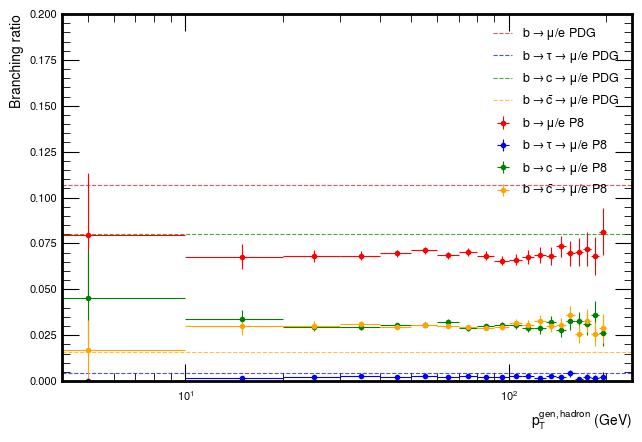

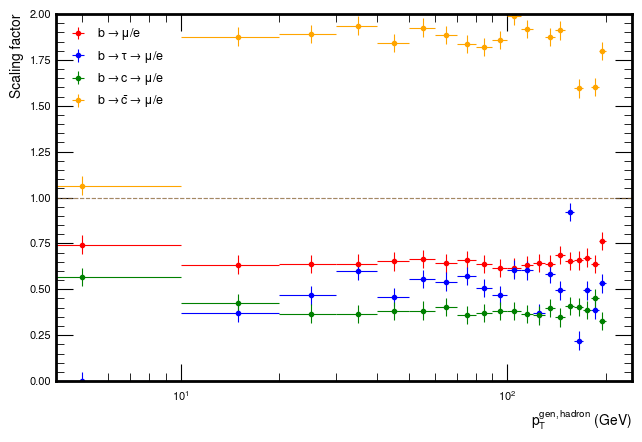

In [32]:
# Create plots for semileptonic
intervals = np.linspace(0, 200, 21)

semileptonic.Branching_ratio_pt(intervals, df_direct, r'$b \rightarrow \mu / e$')
semileptonic.Branching_ratio_pt(intervals, df_tau, r'$b \rightarrow \tau \rightarrow \mu / e$')
semileptonic.Branching_ratio_pt(intervals, df_charm, r'$b \rightarrow c \rightarrow \mu / e$')
semileptonic.Branching_ratio_pt(intervals, df_anticharm, r'$b \rightarrow \bar{c} \rightarrow \mu / e$')


semileptonic.add_pdgBR(r'$b \rightarrow \mu / e$', 0.1069, 'red')
semileptonic.add_pdgBR(r'$b \rightarrow \tau \rightarrow \mu / e$', 0.0045, 'blue')
semileptonic.add_pdgBR(r'$b \rightarrow c \rightarrow \mu / e$', 0.0802, 'green')
semileptonic.add_pdgBR(r'$b \rightarrow \bar{c} \rightarrow \mu / e$', 0.016, 'orange')

semileptonic.plot_results()

In [33]:
%%script false --no raise error
# Plots for specific hadrons
semileptonicB0.Branching_ratio_pt(intervals, df_uncharged_mesons, r'$B0 \rightarrow \mu / e$')
semileptonicBpm.Branching_ratio_pt(intervals, df_charged_mesons, r'$B^\pm \rightarrow \mu / e$')
semileptonicBs.Branching_ratio_pt(intervals, df_strange_mesons, r'$B^0_s \rightarrow \mu / e$')
semileptonicL.Branching_ratio_pt(intervals, df_Lambda, r'$\Lambda^0_s \rightarrow \mu / e$')


semileptonicB0.add_pdgBR(r'$B^0 \rightarrow \mu / e$', 0.1099, 'red')
semileptonicBpm.add_pdgBR(r'$B^\pm \rightarrow \mu / e$', 0.1033, 'blue')
semileptonicBs.add_pdgBR(r'$B^0_s \rightarrow \mu / e$', 0.096, 'green')
semileptonicL.add_pdgBR(r'$\Lambda^0_s \rightarrow \mu / e$', 0.109, 'orange')

semileptonic.plot_results()

In [34]:
%%script false --no raise error
# Plots for inclusive branching ratios
inclusiveB0.Branching_ratio(df_inclusive_unchargedB0, 'D0')
inclusiveB0.Branching_ratio(df_inclusive_chargedB0, 'Dpm')
inclusiveB0.Branching_ratio(df_inclusive_strangeB0, 'Ds')

inclusiveBp.Branching_ratio(df_inclusive_unchargedBp, 'D0')
inclusiveBp.Branching_ratio(df_inclusive_chargedBp, 'Dpm')
inclusiveBp.Branching_ratio(df_inclusive_strangeBp, 'Ds')

inclusiveBs.Branching_ratio(df_inclusive_strange_neg, 'Dsm')

inclusive_individual = inclusiveB0.branching_ratios
inclusive_individual = pd.concat([inclusive_individual, inclusiveBp.branching_ratios], ignore_index=True)
inclusive_individual = pd.concat([inclusive_individual, inclusiveBs.branching_ratios], ignore_index=True)
print(inclusive_individual.to_string())